In [32]:
import gcp.storage as storage
import gcp.bigquery as bq

# Gaps table


In [7]:
%%sql

SELECT COUNT(*) AS count FROM [datalab-projects-1331:xjk_algo_comp.gaps]

count
199386


In [39]:
%%sql --module gaps_histogram
SELECT gap, COUNT(*) AS count FROM [datalab-projects-1331:xjk_algo_comp.gaps]
GROUP BY gap
ORDER BY gap

In [41]:
%%sql
SELECT gap, COUNT(*) AS count FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE gap = 0
GROUP BY gap
ORDER BY gap

gap,count
0.0,96794


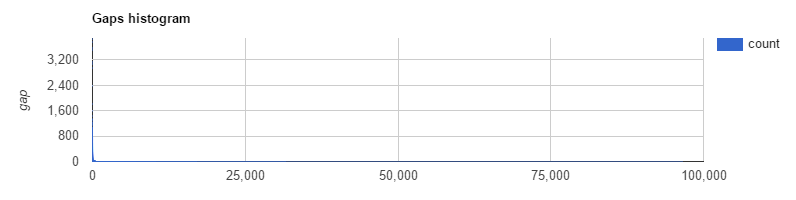

In [36]:
%%chart bars --data gaps_histogram
title: Gaps histogram
vAxis:
  title: gap

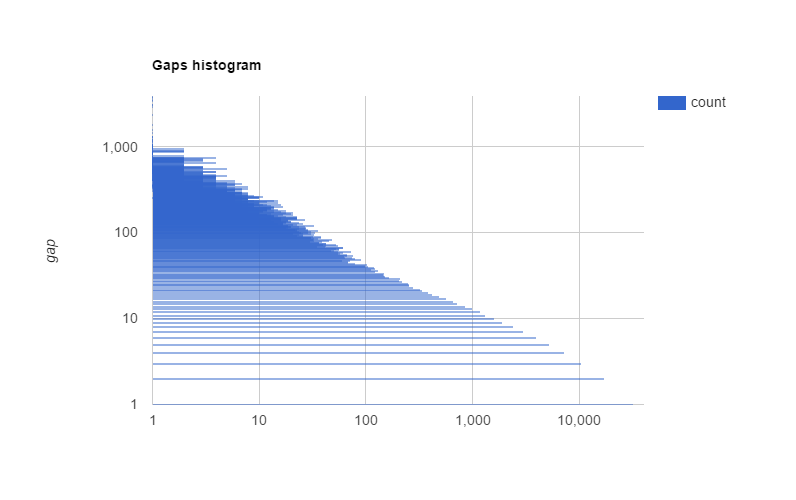

In [40]:
%%chart bars --data gaps_histogram
title: Gaps histogram
height: 500
hAxis:
  scaleType: log
vAxis:
  scaleType: log
  title: gap

Let's go back to some abnormalities we've found earlier, like how there are some timeslots with vastly different number of orders than the rest. Is that pattern prevalent on number of gaps as well? To find this out, we will see how many gaps are there across different timeslots.

In [4]:
%%sql --module gaps_by_timeofday_slot
SELECT timeofday_slot, SUM(gap) AS total_gaps FROM [datalab-projects-1331:xjk_algo_comp.gaps]
GROUP BY timeofday_slot

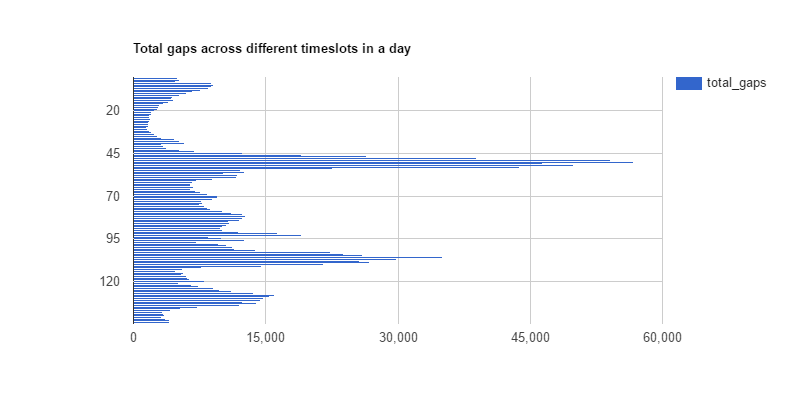

In [5]:
%%chart bars --data gaps_by_timeofday_slot
title: Total gaps across different timeslots in a day
height: 400
vAxis:
  direction: -1

Alright, seems like some timeslots do correlate with higher or lower gaps. This means we do need to include `timeofday_slot` (INTEGER, 1 to 144) as one of our features. Or rather, 144 of our features since we will use one hot encoding on it (explained later).

At this point, I want to see how which variables are correlated with `gap`. The fastest way to do so is by creating a `corrplot` from R:

![corrplot](images/corrplot.png "Corrplot")

(view the image clearer from [this link](https://console.cloud.google.com/m/cloudstorage/b/datalab-projects-1331-datalab/o/others/corrplot.png))

Based on the correlation plot we can tell a few things:
1. Past traffic jams, gaps, and sum prices highly correlate with current `gap`.
2. Many of the POIs are moderately correlated with `gap`.
3. Weather conditions do not correlate with `gap`.
4. From this correlation plot, it seems like `timeofday_slot` does not correlate with `gap`. This is however most likely caused by `timeofday_slot` field contains categorical data. We will be able to tell for sure later after we have done one-hot encoding step.

How are the gaps from subsequent slots related? We need to know this to decide whether to log scale these features.

![gap_cor_1](images/gap_cor_1.png "gap_cor_1")
![gap_cor_2](images/gap_cor_2.png "gap_cor_2")
![gap_cor_3](images/gap_cor_3.png "gap_cor_3")

Looks like there is no need for log scaling here. How about gap with sum price?

![gap_sum_cor_1](images/gap_sum_cor_1.png "gap_sum_cor_1")
![gap_sum_cor_2](images/gap_sum_cor_2.png "gap_sum_cor_2")
![gap_sum_cor_3](images/gap_sum_cor_3.png "gap_sum_cor_3")

We can use sum price features in our model right away without any scaling it seems.


# Problem with exploration

While experimenting with features in this exploration, I found the script runs very slowly when building **gaps** table. I did not focus on making training data building script as effective as possible, instead I worked on it just enough until it is possible to use it for training the model.

# Final Explorations

In [3]:
%sql

SELECT COUNT(*) AS count, SUM(gap) AS sum_gaps FROM [datalab-projects-1331:xjk_algo_comp.gaps]

count,sum_gaps
199386,1513554.0


In [25]:
%sql

SELECT district_id, COUNT(*) AS count, SUM(gap) AS sum_gaps
FROM [datalab-projects-1331:xjk_algo_comp.gaps]
GROUP BY district_id
ORDER BY district_id

district_id,count,sum_gaps
1,3021,18842.0
2,3021,1771.0
3,3021,1934.0
4,3021,23657.0
5,3021,2116.0
6,3021,13544.0
7,3021,109124.0
8,3021,164032.0
9,3021,8010.0
10,3021,2942.0


district_id,count,sum_gaps
1,3021,18842.0
2,3021,1771.0
3,3021,1934.0
4,3021,23657.0
5,3021,2116.0
6,3021,13544.0
7,3021,109124.0
8,3021,164032.0
9,3021,8010.0
10,3021,2942.0


district_id,count,sum_gaps
1,3021,18842.0
2,3021,1771.0
3,3021,1934.0
4,3021,23657.0
5,3021,2116.0
6,3021,13544.0
7,3021,109124.0
8,3021,164032.0
9,3021,8010.0
10,3021,2942.0


Weird, there should be 3024 timeslots on each district but here it is 3021. Let's find out which timeslots are missing.

In [31]:
%sql --module q_gaps_timeslots

SELECT timeslot
FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE district_id = 1
ORDER BY timeslot

In [38]:
gaps_timeslots = [item['timeslot'] for item in bq.Query(q_gaps_timeslots).results()]
print('number of data points: {}'.format(len(gaps_timeslots)))

number of data points: 3021
number of data points: 3021
number of data points: 3021


In [27]:
%%sql --module q_timeslots

SELECT FIRST(timeslot) AS timeslot 
FROM [datalab-projects-1331:xjk_algo_comp.orders] AS orders
GROUP BY date, timeofday_slot
ORDER BY date, timeofday_slot

In [39]:
gaps_timeslots = 
timeslots = [item['timeslot'] for item in bq.Query(q_timeslots).results()]
print('number of data points: {}'.format(len(timeslots)))

SyntaxError: invalid syntax (<ipython-input-39-f521b90dc400>, line 1)

SyntaxError: invalid syntax (<ipython-input-39-f521b90dc400>, line 1)

SyntaxError: invalid syntax (<ipython-input-39-f521b90dc400>, line 1)

In [37]:
gaps_timeslots_df

{u'timeslot'}

{u'timeslot'}

{u'timeslot'}

In [36]:
timeslots_df = set(timeslots_df)
gaps_timeslots_df = set(gaps_timeslots_df)
timeslots_df.remove(gaps_timeslots_df)
timeslots_df.difference(gaps_timeslot_df)


KeyError: set([u'timeslot'])

KeyError: set([u'timeslot'])

KeyError: set([u'timeslot'])

In [6]:
%sql

SELECT count(*) FROM [datalab-projects-1331:xjk_algo_comp.orders]
WHERE timeslot = '2016-01-01-10' AND driver_id = 'NULL'

f0_
3342


In [9]:
%sql

SELECT COUNT(*)
FROM [datalab-projects-1331:xjk_algo_comp.orders]
WHERE timeslot = '2016-01-01-10'
GROUP BY start_district_hash

f0_
3367
29
37
46
3
35
5
8
5
2


In [10]:
%sql

SELECT * FROM [datalab-projects-1331:xjk_algo_comp.weather]
WHERE timeslot = '2016-01-01-1'

time,weather,temperature,pm25,timeslot,timeofday_slot,day_in_week,date
2016-01-01 00:05:24,1,3.0,177.0,2016-01-01-1,1,5,2016-01-01
